# Lab 4 - Pitching Aggregation

## Setup

#### `pandas`

In [10]:
import pandas as pd
from dfply import *
pitching_raw = pd.read_csv('./data/baseball/core/Pitching.csv') 
pitching = (pitching_raw >>
             mutate(id = pitching_raw.index))
pitching.head()

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,...,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP,id
0,bechtge01,1871,1,PH1,NaN,1,2,3,3,2,...,7,NaN,0,146.0,0,42,NaN,NaN,NaN,0
1,brainas01,1871,1,WS3,NaN,12,15,30,30,30,...,7,NaN,0,1291.0,0,292,NaN,NaN,NaN,1
2,fergubo01,1871,1,NY2,NaN,0,0,1,0,0,...,2,NaN,0,14.0,0,9,NaN,NaN,NaN,2
3,fishech01,1871,1,RC1,NaN,4,16,24,24,22,...,20,NaN,0,1080.0,1,257,NaN,NaN,NaN,3
4,fleetfr01,1871,1,NY2,NaN,0,1,1,1,1,...,0,NaN,0,57.0,0,21,NaN,NaN,NaN,4


#### `sqlalchemy`

In [11]:
from sqlalchemy import create_engine
from sqlalchemy.ext.automap import automap_base
from sqlalchemy import select as select_sql

pitching_eng = create_engine("sqlite:///databases/baseball_2_5.db") 
Base = automap_base()
Base.prepare(pitching_eng, reflect=True)
Pitching = Base.classes.pitching
Pitching

sqlalchemy.ext.automap.pitching

In [12]:
stmt = select_sql('*').select_from(Pitching).limit(5)
pd.read_sql_query(stmt, con=pitching_eng)

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,...,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP,id
0,bechtge01,1871,1,PH1,None,1,2,3,3,2,...,7,None,0,146.0,0,42,None,None,None,0
1,brainas01,1871,1,WS3,None,12,15,30,30,30,...,7,None,0,1291.0,0,292,None,None,None,1
2,fergubo01,1871,1,NY2,None,0,0,1,0,0,...,2,None,0,14.0,0,9,None,None,None,2
3,fishech01,1871,1,RC1,None,4,16,24,24,22,...,20,None,0,1080.0,1,257,None,None,None,3
4,fleetfr01,1871,1,NY2,None,0,1,1,1,1,...,0,None,0,57.0,0,21,None,None,None,4


#### `pyspark`

In [13]:
from pyspark.sql import SparkSession
from more_pyspark import get_spark_types, to_pandas

spark = SparkSession.builder.appName('Ops').getOrCreate()

schema = get_spark_types(pitching, keys=['id'])

pitching_spark = spark.createDataFrame(pitching, schema=schema)
(pitching_spark.
   take(5)) >> to_pandas

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,...,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP,id
0,bechtge01,1871,1,PH1,NaN,1,2,3,3,2,...,7,NaN,0,146.0,0,42,NaN,NaN,NaN,0
1,brainas01,1871,1,WS3,NaN,12,15,30,30,30,...,7,NaN,0,1291.0,0,292,NaN,NaN,NaN,1
2,fergubo01,1871,1,NY2,NaN,0,0,1,0,0,...,2,NaN,0,14.0,0,9,NaN,NaN,NaN,2
3,fishech01,1871,1,RC1,NaN,4,16,24,24,22,...,20,NaN,0,1080.0,1,257,NaN,NaN,NaN,3
4,fleetfr01,1871,1,NY2,NaN,0,1,1,1,1,...,0,NaN,0,57.0,0,21,NaN,NaN,NaN,4


## Task 1

Compute and plot the average home runs per game allowed per year for all years in the pitching table.  To accomplish this task, you should

1. Aggregate total `HR` and `IPouts` for each year.
1. Create a `games_pitched` column, which is computed by dividing total inning pitched outs `IPouts` by 27, the number of outs in a game.
2. Create a `hr_per_game` column by dividing the total `HR` for each year by `games_pitched` for each year.
4. Make line plot of the results. You will need to create a new column `HR_per_game` then perform the group and aggregate. You can use [seaborn's lineplot](https://seaborn.pydata.org/generated/seaborn.lineplot.html) to make the graph.

Solve this problem in each framework.

## <font color="red"> Problem 1 </font>

Explain why we might want to total the home runs and outs pitched before dividing.

it's more computationally efficient

## <font color="red"> Problem 2 </font>

Complete the above tasks using `pandas` and `dfply`

In [14]:
hr_per_year = (pitching 
              >> select(X.yearID, X.HR, X.IPouts)
              >> group_by(X.yearID)
              >> summarize(total_hr = X.HR.sum(),
                          total_ipouts = X.IPouts.sum())
              >> mutate (games_pitched = X.total_ipouts/27)
              >> mutate(hr_per_game = X.total_hr/X.games_pitched))
hr_per_year.head()

,yearID,total_hr,total_ipouts,games_pitched,hr_per_game
0,1871,47,6750,250.000000,0.188000
1,1872,37,9858,365.111111,0.101339
2,1873,47,10754,398.296296,0.118003
3,1874,40,12509,463.296296,0.086338
4,1875,40,18571,687.814815,0.058155


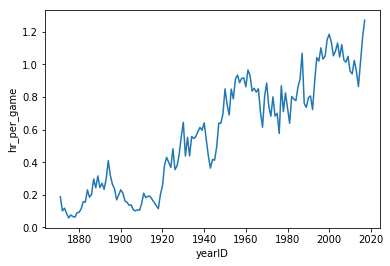

In [15]:
import seaborn as sns
import matplotlib.pylab as plt
sns.lineplot(x = "yearID", y="hr_per_game", data=hr_per_year)

## <font color="red"> Problem 3 </font>

Complete the above tasks using `sqlalchemy`

In [16]:
from sqlalchemy.sql import select as select_sql
from sqlalchemy import func
from more_sqlalchemy import pprint
totals = (select_sql([Pitching.yearID,
                     func.sum(Pitching.HR).label('total_hr'),
                     func.sum(Pitching.IPouts).label('total_ipouts'),
                      ])
        .group_by(Pitching.yearID)
        .alias('totals')
         )
pprint(totals)

SELECT pitching."yearID",
       sum(pitching."HR") AS total_hr,
       sum(pitching."IPouts") AS total_ipouts
FROM pitching
GROUP BY pitching."yearID"


In [17]:
pd.read_sql_query(totals, con=pitching_eng).head()

,yearID,total_hr,total_ipouts
0,1871,47,6750
1,1872,37,9858
2,1873,47,10754
3,1874,40,12509
4,1875,40,18571


In [18]:
from sqlalchemy import text
game_pitched = (select_sql([totals.c.yearID,
                            totals.c.total_ipouts,
                            totals.c.total_hr,
                            (totals.c.total_ipouts/27).label('games_pitched'),
                           ])
               .select_from(totals)
               .alias('games_pitched')
               )
pprint(game_pitched)

SELECT totals."yearID",
       totals.total_ipouts,
       totals.total_hr,
       totals.total_ipouts / :total_ipouts_1 AS games_pitched
FROM
  (SELECT pitching."yearID" AS "yearID",
          sum(pitching."HR") AS total_hr,
          sum(pitching."IPouts") AS total_ipouts
   FROM pitching
   GROUP BY pitching."yearID") AS totals


In [19]:
pd.read_sql_query(game_pitched, con=pitching_eng).head()

,yearID,total_ipouts,total_hr,games_pitched
0,1871,6750,47,250
1,1872,9858,37,365
2,1873,10754,47,398
3,1874,12509,40,463
4,1875,18571,40,687


In [20]:
from sqlalchemy import cast, Float
ratios = (select_sql([game_pitched.c.yearID,
                     (cast(game_pitched.c.total_hr, Float)/game_pitched.c.games_pitched).label('hr_per_game')
                     ])
         .select_from(game_pitched)
         )
pprint(ratios)

SELECT games_pitched."yearID",
       CAST(games_pitched.total_hr AS FLOAT) / games_pitched.games_pitched AS hr_per_game
FROM
  (SELECT totals."yearID" AS "yearID",
          totals.total_ipouts AS total_ipouts,
          totals.total_hr AS total_hr,
          totals.total_ipouts / :total_ipouts_1 AS games_pitched
   FROM
     (SELECT pitching."yearID" AS "yearID",
             sum(pitching."HR") AS total_hr,
             sum(pitching."IPouts") AS total_ipouts
      FROM pitching
      GROUP BY pitching."yearID") AS totals) AS games_pitched


In [21]:
hr_per_game_sql = pd.read_sql_query(ratios, con=pitching_eng)
hr_per_game_sql.head()

,yearID,hr_per_game
0,1871,0.188000
1,1872,0.101370
2,1873,0.118090
3,1874,0.086393
4,1875,0.058224


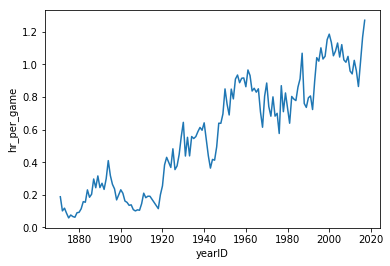

In [22]:
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline
sns.lineplot(x = 'yearID', y = 'hr_per_game', data = hr_per_game_sql)

## <font color="red"> Problem 4 </font>

Complete the above tasks using `pyspark`

In [23]:
import pyspark.sql
select
agg
groupby
with column
collect
>>to_pandas

SyntaxError: invalid syntax (<ipython-input-23-c220c78fce55>, line 5)

In [24]:
import pyspark.sql.functions as fn
hr_per_year = (pitching_spark.
              select([pitching_spark.yearID, 
                     pitching_spark.HR, 
                     pitching_spark.IPouts])
              .agg(fn.sum(pitching_spark.HR).alias('total_HR'),
                  fn.sum(pitching_spark.IPouts).alias('total_ipouts'))
              .groupby(pitching_spark.yearID)
              .withColumn('games_pitched', pitching_spark.total_ipouts/27)
              .withColumn('hr_per_game', pitching_spark.total_hr/pitching_spark.games_pitched)
              .collect()
             ) >> to_pandas >> head

AttributeError: 'GroupedData' object has no attribute 'withColumn'

In [ ]:
sns.lineplot(x = "yearID", y="hr_per_game", data=hr_per_year)

## <font color="blue"> Key for Problem 4</font>

## Task 2

For each year, determine the team that had the most home runs (using the `Pitching.csv` file).

## <font color="red"> Problem 5 </font>

Solve **Task 2** with the framework of your choice.

In [87]:
most_hr = (pitching
          >> select(X.yearID, X.teamID,  X.HR)
          >> group_by(X.yearID, X.teamID)
          >> summarize(tothr = X.HR.sum())
          )
          
most_hr.head()

,teamID,yearID,tothr
0,BS1,1871,2
1,CH1,1871,6
2,CL1,1871,13
3,FW1,1871,5
4,NY2,1871,7


In [88]:
maxhr = (most_hr
        >> select(X.yearID, X.tothr, X.teamID)
        >> group_by(X.yearID)
        >> summarize(maxhr = X.tothr.max())
        )
maxhr.head()

,yearID,maxhr
0,1871,13
1,1872,7
2,1873,11
3,1874,15
4,1875,6
